# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
% matplotlib inline


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# Cleaning and Exploratory analysis

In this section I will have a brief look at the different datasets, one at the time. The goal of this section is to get familiar with the data available, and start investigating the need for and possibilities to clean and impute the data sets if necessary. 

## Portfolio dataset
The portfolio dataset contains information about the different offers that has been issued. We start by investigating each column and the values found, amount of missing values and ranges of data to see what they mean. 

Let's start by looking at the content of the columns

In [6]:
print("portfolio.json has the following shape: ", portfolio.shape)

portfolio.json has the following shape:  (10, 6)


There are 10 offers summarised in the portfolio data. Lets look at all of them as the dataframe is quite small all in all. 

In [7]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [8]:
portfolio.duplicated(subset='id')

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
dtype: bool

We can see from this that there are no missing values and no duplicated IDs. The duration spans from 3 to 10 days, the amount required to spend from 0 (informational offers) to 20 Dollars. The reward span from 0 (informational offers) to 10 Dollars.

We can see that there is a list of channels lumped together. We should prepare this to be dummy values so that we can see if the channel influence at all later. 

We also see that offertype could be represented by dummy values. However, it might be handy still to keep the value in the column, but for potential use in analysis we also add dummy columns for type. 

In [9]:
[c[1] for c in portfolio['channels'].items()]

[['email', 'mobile', 'social'],
 ['web', 'email', 'mobile', 'social'],
 ['web', 'email', 'mobile'],
 ['web', 'email', 'mobile'],
 ['web', 'email'],
 ['web', 'email', 'mobile', 'social'],
 ['web', 'email', 'mobile', 'social'],
 ['email', 'mobile', 'social'],
 ['web', 'email', 'mobile', 'social'],
 ['web', 'email', 'mobile']]

In [10]:
#Get all unique channels
channels = np.unique([channel for chans in portfolio['channels'].items() for channel in chans[1]])
print("Unique channels: ", channels)
portfolio_clean = portfolio.copy(deep=True) #To keep the original dataset, we copy the df
for channel in channels:
    portfolio_clean["channel_" + channel] = portfolio['channels'].apply(lambda l: 1 if channel in l else 0)
portfolio_clean.drop(columns='channels', inplace=True)
portfolio_clean

Unique channels:  ['email' 'mobile' 'social' 'web']


,difficulty,duration,id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [11]:
type_dummies = pd.get_dummies(portfolio_clean['offer_type'] ,prefix='type', prefix_sep='_')
portfolio_clean = pd.concat((portfolio_clean, type_dummies), axis=1, sort=False)


Not much more to do right now on the portfolio data, let's turn our heads to the user data in the profile dataframe.

## Profile dataset
The profile dataset contains information about the users of the Starbucks rewards mobile app. 

Again, lets start by looking a bit on the content. From the above, we could see there are significantly more interesting things happening here with Nans and bad data input. 

But first, lets convert the "became_member_on" column from int to a timestamp to be used later

In [12]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format="%Y%m%d")
profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
print("Profile data set has shape: ", profile.shape)
print("There are {} duplicated user ids".format(profile.duplicated(subset='id').sum()))

Profile data set has shape:  (17000, 5)
There are 0 duplicated user ids


There are 17000 unique users. Let's look at some stats about the content and unique values etc. to see if we should perform some initial cleaning

In [14]:
print("There are these unique gender values: \n", profile['gender'].unique())
print("\nThere are these unique age values: \n", np.sort(profile['age'].unique()))
print("\nThere are these unique income values: \n", np.sort(profile['income'].unique()))
print("\nThere are these unique registered date values: \n", np.sort(profile['became_member_on'].unique()))

There are these unique gender values: 
 [None 'F' 'M' 'O']

There are these unique age values: 
 [ 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 118]

There are these unique income values: 
 [  30000.   31000.   32000.   33000.   34000.   35000.   36000.   37000.
   38000.   39000.   40000.   41000.   42000.   43000.   44000.   45000.
   46000.   47000.   48000.   49000.   50000.   51000.   52000.   53000.
   54000.   55000.   56000.   57000.   58000.   59000.   60000.   61000.
   62000.   63000.   64000.   65000.   66000.   67000.   68000.   69000.
   70000.   71000.   72000.   73000.   74000.   75000.   76000.   77000.
   78000.   79000.   80000.   81000.   82000.   83000.   84000.   85000.
   86

From the above we see that the are nans in income values and gender values. The rest seem to have values. 

However, the age column is a sneaky one. We can see quite alot of values above 90, could any of these be acting as a default value, if the user does not give the real one?

### Age and age distribution

Lets have a closer look at the number of users for each age bin

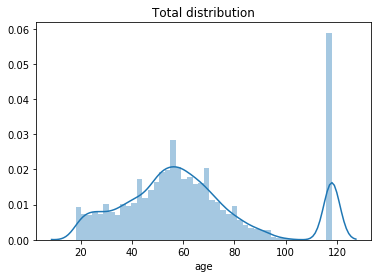

In [15]:
ax = sns.distplot(profile['age']);
ax.set_title('Total distribution');

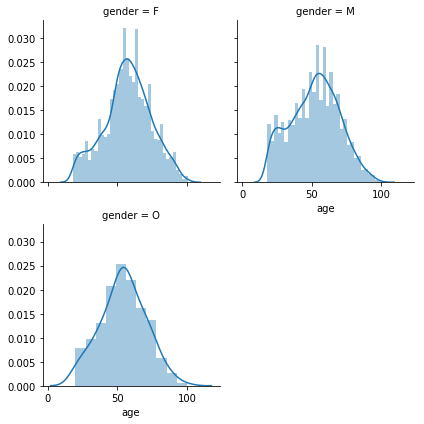

In [16]:
g = sns.FacetGrid(profile, col='gender', col_wrap=2)
g.map(sns.distplot, 'age');

In [17]:
profile_gender_mod = profile.copy(deep=True)

profile_gender_mod['gender'] = profile['gender'].apply(lambda g: 'Unknown' if g is None else g)

print("For gender None, the unique values of age column is: ")
profile_gender_mod.loc[profile_gender_mod['gender']=='Unknown', 'age'].unique()[0]

For gender None, the unique values of age column is: 


118

We see that when we make a distribution of **all** the users there is a significant amount of entries at age 118. The other genders are fairly representative distributions


However, when we plot the subsets by gender, we can see that there is basically no entries above 100 years of age. That's more expected. We also see that there is a 1:1 correlation between not having a gender, and having the age of 118. Thus we can conclude that this is probably a default value for a user that has not set any profile values. We should maybe mark age 118 as nan. 

A natural hypothesis is then that the missing income values are also linked to these users. Let's dig into rows with None gender as value.

### "Default" profiles - not updated information

In [18]:
profile_None_gender = profile.loc[profile['gender'].isna(),:]
profile_None_gender.head(10)

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,2016-11-22,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,2017-08-24,None,c4863c7985cf408faee930f111475da3,NaN
11,118,2015-09-19,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,2017-08-01,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,2017-09-07,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [19]:
print("Unique values of income for users with None gender: ", profile_None_gender['income'].unique())

Unique values of income for users with None gender:  [ nan]


We can see that also the income has only nan values when the gender is not set, what I have named a default profile. We still don't know if the users here are uninteresting. After investigating the transactions data by itself we should investigate if the users with a default user profile have a significant portion of the transactions. If it has it may be interesting to treat all default profiles as one group to see if there are any difference between the default profiles and the users that has updated their profile with information. 

However, for now I will remove any user from the profile data to look at the remaining data, and if there are missing values left after this removal. 

In [20]:
print("There are {} users with a default profile, meaning no gender, no income and age 118".format(profile_None_gender.shape[0]))
print("That is {:.2f}% of the total users registered".format(100 * (profile_None_gender.shape[0] / profile.shape[0])))

There are 2175 users with a default profile, meaning no gender, no income and age 118
That is 12.79% of the total users registered


### profile data without default profiles

In [30]:
profile_no_default = profile.loc[~profile['gender'].isna(),:]
profile_no_default.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


First lets check if there are any missing values left in any profile

In [31]:
print("Number of missing income values: ", profile_no_default['income'].isna().sum())
print("Number of missing date values: ", profile_no_default['became_member_on'].isna().sum())
print("Number of missing gender values: ", profile_no_default['gender'].isna().sum())
print("Number of age values equal to 118: ", (profile_no_default['age'] == 118).sum())
print("Number of missing id values: ", profile_no_default['id'].isna().sum())


Number of missing income values:  0
Number of missing date values:  0
Number of missing gender values:  0
Number of age values equal to 118:  0
Number of missing id values:  0


Great, no missing values in the rest of the user data. However, for the sake of clarity, lets look again at distributions etc. to see if there are any artifacts remaining

#### Registration date distributions

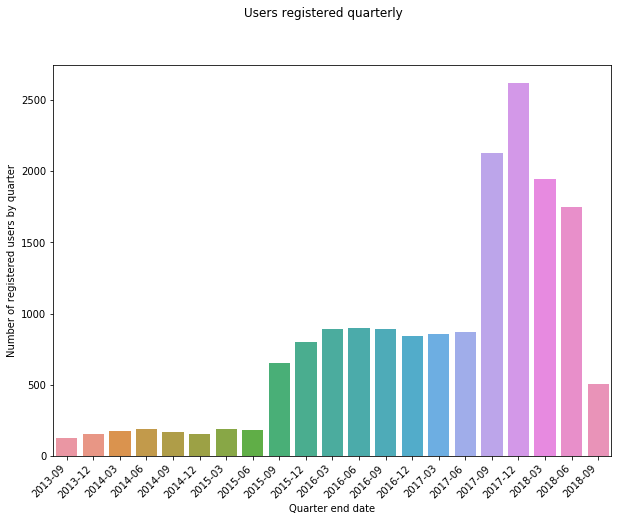

In [32]:
#Distribution of registration by month for all users
member_grouped_month = profile.set_index('became_member_on').groupby(pd.Grouper(freq='Q')).count()
month_bins = member_grouped_month.index.strftime("%Y-%m")
datefmt = mdates.DateFormatter("%Y-%M")
fig,ax = plt.subplots(1,1,figsize=(10,8));
fig.autofmt_xdate(rotation=45)
sns.barplot(x=month_bins, y=member_grouped_month['age'], ax=ax);
fig.suptitle('Users registered quarterly');
ax.set_xlabel('Quarter end date');
ax.set_ylabel('Number of registered users by quarter');

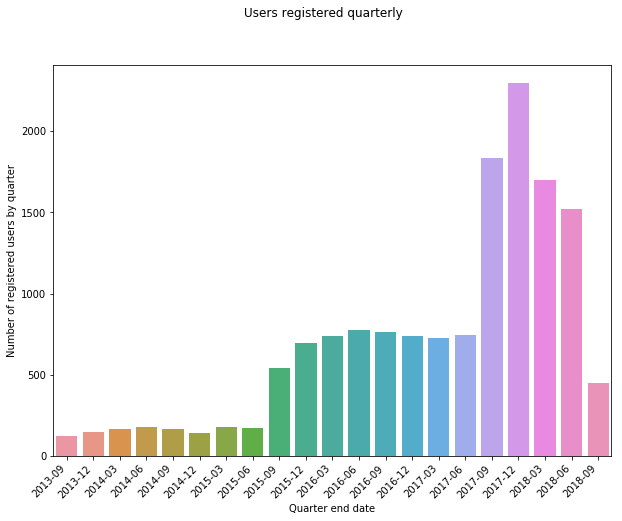

In [33]:
#Distribution of registration by month for non-default user profiles
member_grouped_month = profile_no_default.set_index('became_member_on').groupby(pd.Grouper(freq='Q')).count()
month_bins = member_grouped_month.index.strftime("%Y-%m")
datefmt = mdates.DateFormatter("%Y-%M")
fig,ax = plt.subplots(1,1,figsize=(10,8));
fig.autofmt_xdate(rotation=45)
sns.barplot(x=month_bins, y=member_grouped_month['age'], ax=ax);
fig.suptitle('Users registered quarterly');
ax.set_xlabel('Quarter end date');
ax.set_ylabel('Number of registered users by quarter');


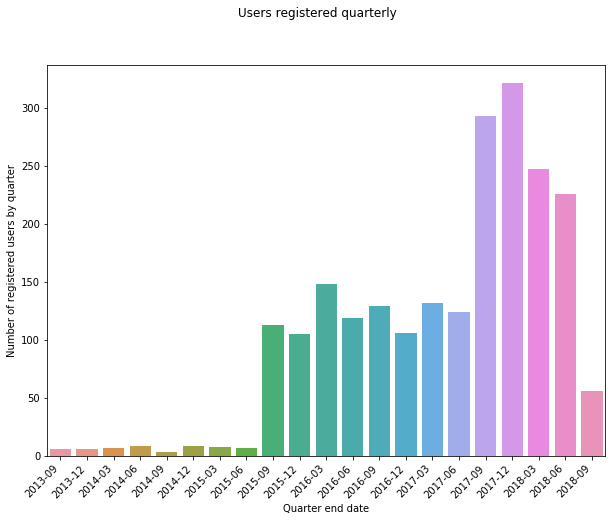

In [34]:
#Distribution of registration by month for default user profiles
member_grouped_month = profile_None_gender.set_index('became_member_on').groupby(pd.Grouper(freq='Q')).count()
month_bins = member_grouped_month.index.strftime("%Y-%m")
datefmt = mdates.DateFormatter("%Y-%M")
fig,ax = plt.subplots(1,1,figsize=(10,8));
fig.autofmt_xdate(rotation=45)
sns.barplot(x=month_bins, y=member_grouped_month['age'], ax=ax);
fig.suptitle('Users registered quarterly');
ax.set_xlabel('Quarter end date');
ax.set_ylabel('Number of registered users by quarter');

The distributions for member registration date does not seem to change significantly if we remove the default profiles. We can see that the default user registrations are primarily from third quarter in 2015 and onward. However, that's also when the general userbase picked up. We can look at the %of defualt users and its distribution as well.

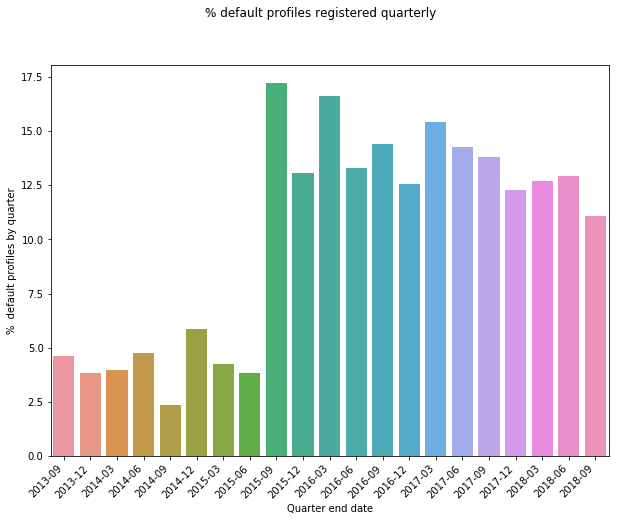

In [35]:
member_grouped_month_default = profile_None_gender.set_index('became_member_on').groupby(pd.Grouper(freq='Q')).count()
member_grouped_month_all = profile.set_index('became_member_on').groupby(pd.Grouper(freq='Q')).count()
member_grouped_default_pct = 100 * member_grouped_month_default/member_grouped_month_all

#Distribution of registration by month for default user profiles
month_bins = member_grouped_default_pct.index.strftime("%Y-%m")
datefmt = mdates.DateFormatter("%Y-%M")
fig,ax = plt.subplots(1,1,figsize=(10,8));
fig.autofmt_xdate(rotation=45)
sns.barplot(x=month_bins, y=member_grouped_default_pct['age'], ax=ax);
fig.suptitle('% default profiles registered quarterly');
ax.set_xlabel('Quarter end date');
ax.set_ylabel('%  default profiles by quarter');

We see that there is indeed a higher portion of default profiles after 3rd quarter of 2015. However, it may not be important as it seems to be quite evenly distributed before and after that quarter

#### Gender distribution

Below we see the gender distribution for registered genders. 57.2% of the users are male, 41.3% are female and 1.4% are Other. 

The low ratio of Other gender could make it difficult to say much about this usergroup, unless they have very strong tendencies. 

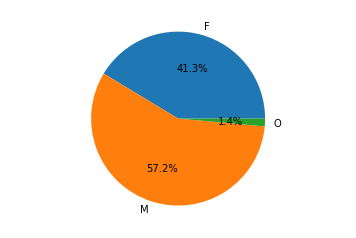

In [36]:
#gender distribution of remaining users
sums = profile_no_default.groupby('gender').count()
plt.axis('equal')
plt.pie(sums['age'].values, labels=sums.index, autopct='%.1f%%');

#### Income distribution

In [50]:
bins = pd.cut(profile_no_default.loc[:,'income'], 20)
profile_no_default.loc[:,'income_bins'] = bins
profile_no_default.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,age,became_member_on,gender,id,income,income_bins
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,"(111000.0, 115500.0]"
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,"(97500.0, 102000.0]"
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,"(66000.0, 70500.0]"
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,"(52500.0, 57000.0]"
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,"(48000.0, 52500.0]"


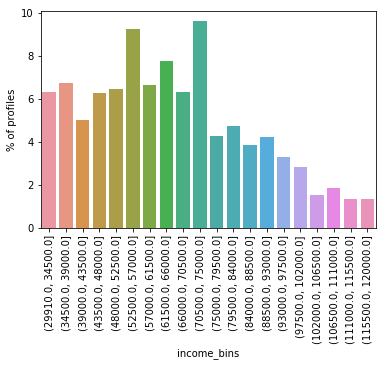

In [71]:
profiles_per_income = profile_no_default.groupby(by='income_bins').count()
profiles_per_income_pct = 100* profiles_per_income/profiles_per_income.sum(axis=0)
ax = sns.barplot(x=profiles_per_income_pct.index, y=profiles_per_income_pct['age'])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('% of profiles');

In [72]:
profiles_per_income = profile_no_default.groupby(by=['gender', 'income_bins']).count()
profiles_per_income_male = profiles_per_income.loc['M']
profiles_per_income_female = profiles_per_income.loc['F']
profiles_per_income_other = profiles_per_income.loc['O']


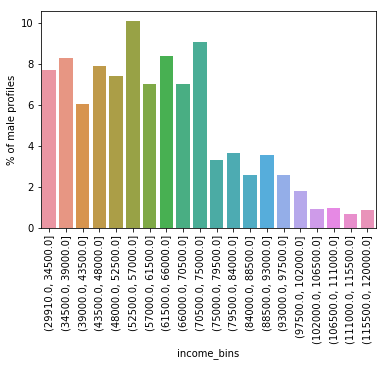

In [73]:
profiles_per_income_pct = 100* profiles_per_income_male/profiles_per_income_male.sum(axis=0)
ax = sns.barplot(x=profiles_per_income_pct.index, y=profiles_per_income_pct['age'])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('% of male profiles');

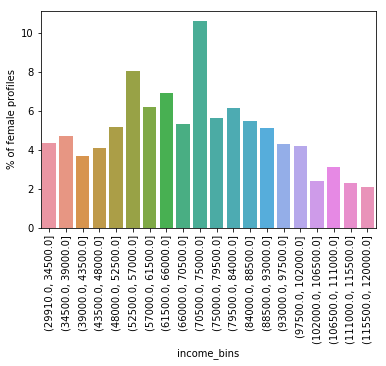

In [74]:
profiles_per_income_pct = 100* profiles_per_income_female/profiles_per_income_female.sum(axis=0)
ax = sns.barplot(x=profiles_per_income_pct.index, y=profiles_per_income_pct['age'])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('% of female profiles');

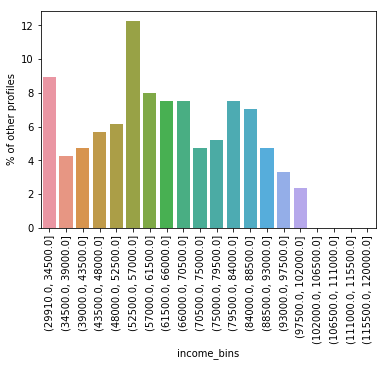

In [75]:
profiles_per_income_pct = 100* profiles_per_income_other/profiles_per_income_other.sum(axis=0)
ax = sns.barplot(x=profiles_per_income_pct.index, y=profiles_per_income_pct['age'])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('% of other profiles');

We can see from the above distribution that the income is quite evenly spread out between users up to 75kUSD where the number of users in each bin start to taper of. There are quite few in each bin from 102kUSD and upwards. However, still almost 200 users. 

Also, from the gender specific distributions we see that the females are actually more evenly distributed than the two others, and have relatively larger ratio of high income users. The other gender has no user with income above 102kUSD. 

### Transcript data

Finally, lets dig into the transcript data. 

In [76]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


Initially we see that the event gives the type of interaction, person is the user_id, time is the hours since start of test, and value has a dictionary of key value pairs.

Any missing values?

In [85]:
transcript.isna().sum(axis=0)

event     0
person    0
time      0
value     0
dtype: int64

In [81]:
print("unique event values: ", transcript['event'].unique())
transcript.groupby('event').count()

unique event values:  ['offer received' 'offer viewed' 'transaction' 'offer completed']


,person,time,value
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


There is no missing values, luckily. And we can also see that there are quite alot of offers not being viewed, and even fewer completed. However,we no nothing about how many offers that are viewed are completed and how many are not etc. 

We will investigate this a bit later, but first lets look at the value column and see if we can split it in some simle way into type and value. 

Is there always one key,item pair?

In [92]:
transcript['value'].apply(lambda d: len(d.keys())).unique()

array([1, 2])

No, some entries actually has two keys. In what cases does that happen?

In [111]:
transcript['value_keys'] = transcript['value'].apply(lambda d: list(d.keys()))
transcript['num_value_keys'] = transcript['value'].apply(lambda d: len(d.keys()))
print("Events with more than 1 value key: ", transcript.loc[transcript['num_value_keys']>1,'event'].unique())
transcript.loc[transcript['num_value_keys']>1].iloc[:1,:]

Events with more than 1 value key:  ['offer completed']


,event,person,time,value,value_keys,num_value_keys
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,"[offer_id, reward]",2


We see that there is only the offer completed event that has more than 1 value key and that the keys are offer_id and reward. The reward is the amount released when the offer is completed. 

What other keys are there? And are there any entries missing keys?

In [115]:
keys = []
transcript.loc[:,'value_keys'].apply(lambda l: keys.extend(l))
set(keys)

{'amount', 'offer id', 'offer_id', 'reward'}

In [117]:
transcript.loc[transcript.loc[:,'value_keys']==0,:]

,event,person,time,value,value_keys,num_value_keys


There is in princple 3 different keys, since "offer id" and "offer_id" can be expected to be one and the same value. 

We should find a way to represent this data in a reasonable way so that we can use it more easily. The keys are not present in all entries, thus we should split the values into three columns, and for now at least we will fill with nan values where the key value is not valid. 

In [ ]:
x[value][key] for key in x['value_keys'] if key in ["offer_id", "offer id"]

In [201]:
def value_return(x, wanted_key = []):
    for key in x['value_keys']:
        if key in wanted_key:
            return x['value'][key]
    return np.nan

offer_id = transcript.loc[:,['value_keys','value']].apply(value_return, axis=1, wanted_key=['offer_id', 'offer id'])
amount = transcript.loc[:,['value_keys','value']].apply(value_return, axis=1, wanted_key=['amount'])
reward = transcript.loc[:,['value_keys','value']].apply(value_return, axis=1, wanted_key=['reward'])

In [203]:
transcript['offer_id'] = offer_id
transcript['amount'] = amount
transcript['reward'] = reward

In [207]:
transcript[~transcript['amount'].isna()].head()

,event,person,time,value,value_keys,num_value_keys,offer_id,amount,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},[amount],1,NaN,0.83,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},[amount],1,NaN,34.56,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},[amount],1,NaN,13.23,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},[amount],1,NaN,19.51,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},[amount],1,NaN,18.97,NaN


In [208]:
transcript[~transcript['reward'].isna()].head()

,event,person,time,value,value_keys,num_value_keys,offer_id,amount,reward
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,"[offer_id, reward]",2,2906b810c7d4411798c6938adc9daaa5,NaN,2.0
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,"[offer_id, reward]",2,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,"[offer_id, reward]",2,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,"[offer_id, reward]",2,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10.0
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,"[offer_id, reward]",2,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0


In [209]:
transcript[~transcript['offer_id'].isna()].head()

,event,person,time,value,value_keys,num_value_keys,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},[offer id],1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},[offer id],1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},[offer id],1,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},[offer id],1,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},[offer id],1,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [211]:
transcript[transcript['person']==transcript.loc[0, 'person']]

,event,person,time,value,value_keys,num_value_keys,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},[offer id],1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},[offer id],1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},[amount],1,NaN,19.89,NaN
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,"[offer_id, reward]",2,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},[amount],1,NaN,17.78,NaN
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},[offer id],1,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},[offer id],1,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67},[amount],1,NaN,19.67,NaN
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72},[amount],1,NaN,29.72,NaN
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93},[amount],1,NaN,23.93,NaN


In [212]:
pd.__version__

'0.23.3'

In [221]:
transcript.to_parquet("transcript_mod.parquet")

RuntimeError: Compression 'snappy' not available.  Options: ['GZIP', 'UNCOMPRESSED']

In [222]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.3.final.0
python-bits: 64
OS: Linux
OS-release: 4.15.0-1033-gcp
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: en_US.UTF-8
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8

pandas: 0.23.3
pytest: 4.5.0
pip: 18.1
setuptools: 38.4.0
Cython: 0.29.7
numpy: 1.12.1
scipy: 0.19.1
pyarrow: None
xarray: None
IPython: 6.5.0
sphinx: None
patsy: 0.4.1
dateutil: 2.6.1
pytz: 2017.3
blosc: None
bottleneck: None
tables: None
numexpr: 2.6.4
feather: None
matplotlib: 2.1.0
openpyxl: 2.5.0b1
xlrd: 1.1.0
xlwt: None
xlsxwriter: None
lxml: 4.1.1
bs4: 4.6.0
html5lib: 0.9999999
sqlalchemy: 1.1.13
pymysql: None
psycopg2: 2.7.4 (dt dec pq3 ext lo64)
jinja2: 2.10
s3fs: None
fastparquet: 0.3.2
pandas_gbq: None
pandas_datareader: None


In [223]:
import snappy

ModuleNotFoundError: No module named 'snappy'